# Predicting Cryptocurrency Price Using Time Series Analysis - **CODE**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
sns.set_style("ticks")

from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import KFold

C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


### 2.2 Preprocessing

In [2]:
# Import Libraries
import requests
from dateutil.relativedelta import relativedelta

# CoinDesk 20
coindesk20_list = ['BTC', 'ETH', 'XRP', 'ADA', 'USDT', 'DOGE', 'XLM', 'DOT', 'UNI', 'LINK', 'USDC', 'BCH', 'LTC', 'GRT', 'ETC', 'FIL', 'AAVE', 'ALGO', 'EOS']
raw_df = pd.DataFrame()
for coin in coindesk20_list:
    coin_df = pd.DataFrame()
    df = pd.DataFrame(index=[0])
    
    # Define the Start Date and End Date
    end_datetime = datetime(2021, 8, 1, 0, 0)
    datetime_checkpt = datetime(2021, 7, 1, 0, 0)
    
    while len(df) > 0:
        if end_datetime == datetime_checkpt:
            break
        start_datetime = end_datetime - relativedelta(hours = 12)
        url = 'https://production.api.coindesk.com/v2/price/values/' + coin + '?start_date=' + start_datetime.strftime("%Y-%m-%dT%H:%M") + '&end_date=' + end_datetime.strftime("%Y-%m-%dT%H:%M") + '&ohlc=true'
        temp_data_json = requests.get(url)
        temp_data = temp_data_json.json()
        df = pd.DataFrame(temp_data['data']['entries'])
        df.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close']
        
        # Handle the Missing Data
        insert_idx_list = [np.nan]
        while len(insert_idx_list) > 0:
            timestamp_checking_array = np.array(df['Timestamp'][1:]) - np.array(df['Timestamp'][:-1])
            insert_idx_list = np.where(timestamp_checking_array != 60000)[0]
            if len(insert_idx_list) > 0:
                print('There are ' + str(len(insert_idx_list)) + ' timestamp mismatched.')
                insert_idx = insert_idx_list[0]
                temp_df = df.iloc[insert_idx.repeat(int(timestamp_checking_array[insert_idx]/60000)-1)].reset_index(drop=True)
                temp_df['Timestamp'] = [temp_df['Timestamp'][0] + i*60000 for i in range(1, len(temp_df)+1)]
                df = df.loc[:insert_idx].append(temp_df).append(df.loc[insert_idx+1:]).reset_index(drop=True)
                insert_idx_list = insert_idx_list[1:]
        
        df = df.drop(['Timestamp'], axis=1)
        df['Datetime'] = [end_datetime - relativedelta(minutes=len(df)-i) for i in range(0, len(df))]
        coin_df = df.append(coin_df)
        end_datetime = start_datetime
    coin_df['Symbol'] = coin
    raw_df = raw_df.append(coin_df)
raw_df = raw_df[['Datetime', 'Symbol', 'Open', 'High', 'Low', 'Close']].reset_index(drop=True)
raw_df.to_csv('raw_df.csv', index=False)

There are 1 timestamp mismatched.
There are 21 timestamp mismatched.
There are 20 timestamp mismatched.
There are 19 timestamp mismatched.
There are 18 timestamp mismatched.
There are 17 timestamp mismatched.
There are 16 timestamp mismatched.
There are 15 timestamp mismatched.
There are 14 timestamp mismatched.
There are 13 timestamp mismatched.
There are 12 timestamp mismatched.
There are 11 timestamp mismatched.
There are 10 timestamp mismatched.
There are 9 timestamp mismatched.
There are 8 timestamp mismatched.
There are 7 timestamp mismatched.
There are 6 timestamp mismatched.
There are 5 timestamp mismatched.
There are 4 timestamp mismatched.
There are 3 timestamp mismatched.
There are 2 timestamp mismatched.
There are 1 timestamp mismatched.
There are 1 timestamp mismatched.
There are 1 timestamp mismatched.
There are 21 timestamp mismatched.
There are 20 timestamp mismatched.
There are 19 timestamp mismatched.
There are 18 timestamp mismatched.
There are 17 timestamp mismatche

In [3]:
eth = raw_df[raw_df['Symbol']=='ETH'].reset_index(drop=True)
eth = eth.set_index('Datetime')
eth.drop('Symbol', axis=1, inplace=True)

h3_eth = eth.head(180)
h2_eth = eth.head(120)
h1_eth = eth.head(60)

hour1 = h1_eth['Close']
hour2 = h2_eth['Close']
hour3 = h3_eth['Close']

eth.head()

,Open,High,Low,Close
Datetime,,,,
2021-07-01 00:00:00,2275.689004,2276.012712,2270.817381,2271.039330
2021-07-01 00:01:00,2270.757013,2273.876893,2268.116536,2268.116536
2021-07-01 00:02:00,2267.872379,2268.890654,2263.936290,2266.642162
2021-07-01 00:03:00,2266.678344,2267.985446,2263.985129,2263.985129
2021-07-01 00:04:00,2263.925150,2268.598650,2263.878995,2266.235855


## **1-Hour Data**

### 3.1 Seasonal Decomposition

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from pandas.plotting import autocorrelation_plot 

In [45]:
def trend_plot(data, trend, interval):
    fig, ax = plt.subplots()
    ax.grid(True)
    year = mdates.YearLocator(month=1)
    month = mdates.MonthLocator(interval=3)
    year_format = mdates.DateFormatter('%Y')
    month_format = mdates.DateFormatter('%m')
    ax.xaxis.set_minor_locator(month)
    ax.xaxis.grid(True, which = 'minor')
    ax.xaxis.set_major_locator(year)
    ax.xaxis.set_major_formatter(year_format)
    plt.plot(np.array(data.index), np.array(data), c='blue')
    plt.plot(np.array(data.index), np.array(trend), c='red',lw=2)
    plt.ylabel('Closing Price (ETH)', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.title('Price Data with Decomposition Trend Overlay \n (Interval = ' + interval + ')', fontsize=18)

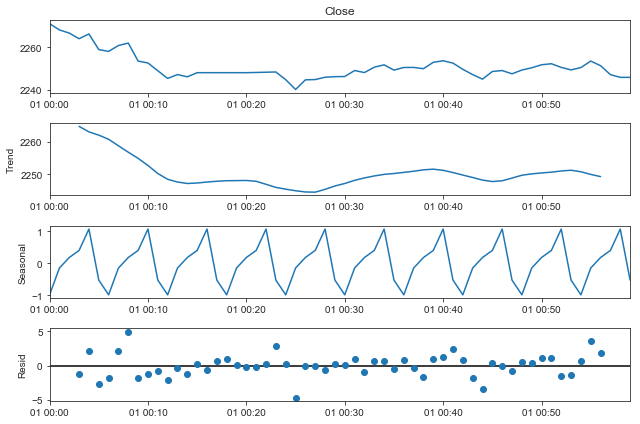

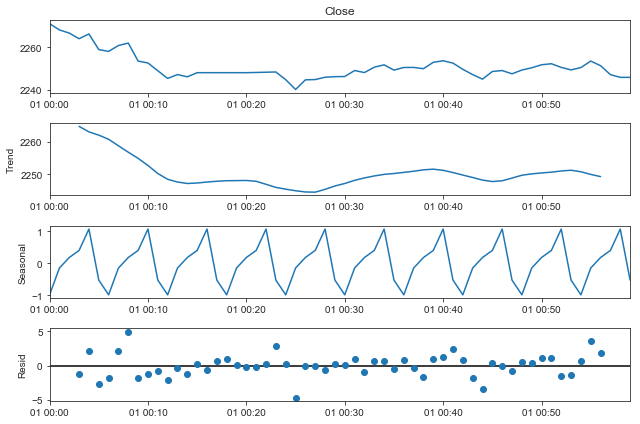

In [46]:
decompfreq = 6
h1_result = sd(hour1, model='Multiplicative', period=decompfreq)
h1_trend = h1_result.trend
h1_season = h1_result.seasonal
h1_error = h1_result.resid

plt.rcParams['figure.figsize'] = [9.0,6.0]
h1_result.plot()

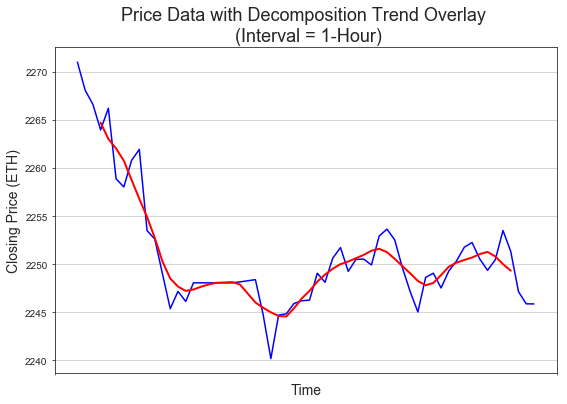

In [47]:
trend_plot(hour1, h1_trend, '1-Hour')

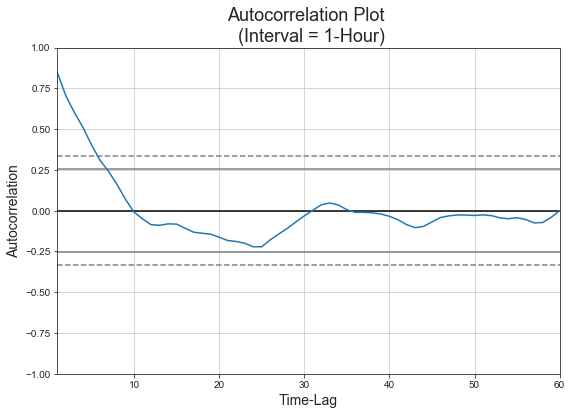

In [49]:
autocorrelation_plot(h1_eth)
plt.ylabel('Autocorrelation', fontsize=14)
plt.xlabel('Time-Lag', fontsize=14)
plt.title('Autocorrelation Plot \n (Interval = 1-Hour)', fontsize=18)
plt.show()

### 3.2 Standard Autoregressive and Autoregressive Integrated Moving Average Models

In [4]:
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import kstest, anderson, shapiro

In [5]:
def run_AutoReg(data, lag, interval='1-Hour', title='AutoReg', component=None, component_dict=None):  
    
    results = []
    
    if component:
        history = list(component_dict[component].iloc[:int(len(h1_eth) * 0.8)])
        test = component_dict[component].iloc[int(len(h1_eth) * 0.8):]
        predictions = []

        for t in range(len(test)):
            model = AutoReg(history, lags=13)
            model_fit = model.fit()
            pred = model_fit.predict(start=len(history), end=len(history), dynamic=False)
            predictions.append(pred[0])
            history.append(test[t])

        predictions = pd.Series(predictions, index=test.index, name=component)
        results.append(predictions)
        test_mse = np.sqrt(mse(test, predictions))
        test_r2 = r2_score(test, predictions)

        print(f'Test for {component} MSE: {test_mse}')
        print(f'Test for {component} R^2: {test_r2}')

        # plot results
        plt.plot(test.iloc[:], label='Observed '+ component)
        plt.plot(predictions.iloc[:], color='red', label='Predicted '+ component)
        plt.ylabel('Closing Price (ETH)', fontsize=14)
        plt.xlabel('Test Time Periods \n (Interval = '+interval+')', fontsize=14)
        plt.title(title+' ('+component+')', fontsize=18)
        plt.legend(['Test Price', 'Predicted Price'], fontsize=12)

        plt.show()
        
        # evaluate residuals
        residuals = pd.DataFrame(model_fit.resid)
        residuals = residuals.drop(residuals.index[0])
        residuals.plot()
        plt.ylabel("Residuals", fontsize=14)
        plt.xlabel("Datetime", fontsize=14)
        plt.show()
        residuals.plot(kind='kde')
        plt.ylabel("Density", fontsize=14)
        plt.show()

        # Normality tests of residual errors
        res = residuals.values
        dist= getattr(stats, 'norm')
        params = dist.fit(res)
        print("Mean of residuals: ", params[0])
        print("Standard deviation of residuals: ", params[1])

        # Kolmogorov-Smirnov Test
        print(kstest(res, 'norm', params))

        # Anderson-Darling Test
        res = res.ravel()
        print(anderson(res, dist='norm'))

        # Shapiro-Wilke Test
        sw = shapiro(res)
        print('Shapiro-Wilke test statistic is {0} and p-value is {1}'.format(sw[0], sw[1])) 
    else:
        
        historic = list(data.iloc[:int(len(data) * 0.8)])
        test = data.iloc[int(len(data) * 0.8):]
        predictions = []

        for t in range(len(test)):
            model = AutoReg(historic, lags=lag)
            model_fit = model.fit()
            pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
            predictions.append(pred[0])
            historic.append(test[t])

        predictions = pd.Series(predictions, index=test.index)

        test_mse = np.sqrt(mse(test, predictions))
        test_score = r2_score(test, predictions)

        print('Test MSE: %.5f' % test_mse)
        print('Test R^2: %.5f' % test_score)

        # plot results
        plt.plot(test, label='Prices')
        plt.plot(predictions, color='red', label='Prediction')
        plt.ylabel('Closing Price (ETH)', fontsize=14)
        plt.xlabel('Test Time Periods \n (Interval = '+interval+')', fontsize=14)
        plt.tick_params(labelbottom=False, bottom=False)
        plt.title(title, fontsize=18)
        plt.legend(['Test Price', 'Predicted Price'], fontsize=12)
        plt.show()

        # evaluate residuals
        residuals = pd.DataFrame(model_fit.resid)
        residuals = residuals.drop(residuals.index[0])
        residuals.plot()
        plt.ylabel("Residuals", fontsize=14)
        plt.xlabel("Datetime", fontsize=14)
        plt.show()
        residuals.plot(kind='kde')
        plt.ylabel("Density", fontsize=14)
        plt.show()

        # Normality tests of residual errors
        res = residuals.values
        dist= getattr(stats, 'norm')
        params = dist.fit(res)
        print("Mean of residuals: ", params[0])
        print("Standard deviation of residuals: ", params[1])

        # Kolmogorov-Smirnov Test
        print(kstest(res, 'norm', params))

        # Anderson-Darling Test
        res = res.ravel()
        print(anderson(res, dist='norm'))

        # Shapiro-Wilke Test
        sw = shapiro(res)
        print('Shapiro-Wilke test statistic is {0} and p-value is {1}'.format(sw[0], sw[1]))

In [6]:
def run_ARIMA(data, order, interval='1-Hour', title='ARIMA', component=None, component_dict=None):
    
    results = []
    
    if component:
        history = list(component_dict[component].iloc[:int(len(h1_eth) * 0.8)])
        test = component_dict[component].iloc[int(len(h1_eth) * 0.8):]
        predictions = []

        for t in range(len(test)):
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            pred = model_fit.predict(start=len(history), end=len(history), dynamic=False)
            predictions.append(pred[0])
            history.append(test[t])

        predictions = pd.Series(predictions, index=test.index, name=component)
        results.append(predictions)
        test_mse = np.sqrt(mse(test, predictions))
        test_r2 = r2_score(test, predictions)

        print(f'Test for {component} MSE: {test_mse}')
        print(f'Test for {component} R^2: {test_r2}')

        # plot results
        plt.plot(test.iloc[:], label='Observed '+ component)
        plt.plot(predictions.iloc[:], color='red', label='Predicted '+ component)
        plt.ylabel('Closing Price (ETH)', fontsize=14)
        plt.xlabel('Test Time Periods \n (Interval = '+interval+')', fontsize=14)
        plt.title(title+' ('+component+')', fontsize=18)
        plt.legend(['Test Price', 'Predicted Price'], fontsize=12)

        plt.show()
        
        # evaluate residuals
        residuals = pd.DataFrame(model_fit.resid)
        residuals = residuals.drop(residuals.index[0])
        residuals.plot()
        plt.ylabel("Residuals", fontsize=14)
        plt.xlabel("Datetime", fontsize=14)
        plt.show()
        residuals.plot(kind='kde')
        plt.ylabel("Density", fontsize=14)
        plt.show()

        # Normality tests of residual errors
        res = residuals.values
        dist= getattr(stats, 'norm')
        params = dist.fit(res)
        print("Mean of residuals: ", params[0])
        print("Standard deviation of residuals: ", params[1])

        # Kolmogorov-Smirnov Test
        print(kstest(res, 'norm', params))

        # Anderson-Darling Test
        res = res.ravel()
        print(anderson(res, dist='norm'))

        # Shapiro-Wilke Test
        sw = shapiro(res)
        print('Shapiro-Wilke test statistic is {0} and p-value is {1}'.format(sw[0], sw[1]))
        
    else: 
        historic = list(data.iloc[:int(len(data) * 0.8)])
        test = data.iloc[int(len(data) * 0.8):]
        predictions = []

        for t in range(len(test)):
            model = ARIMA(historic, order=order)
            model_fit = model.fit()
            pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
            predictions.append(pred[0])
            historic.append(test[t])

        predictions = pd.Series(predictions, index=test.index)

        test_mse = np.sqrt(mse(test, predictions))
        test_score = r2_score(test, predictions)

        print('Test MSE: %.5f' % test_mse)
        print('Test R^2: %.5f' % test_score)

        # plot results
        plt.plot(test, label='Prices')
        plt.plot(predictions, color='red', label='Prediction')
        plt.ylabel('Closing Price (ETH)', fontsize=14)
        plt.xlabel('Test Time Periods \n (Interval = '+interval+')', fontsize=14)
        plt.tick_params(labelbottom=False, bottom=False)
        plt.title(title, fontsize=18)
        plt.legend(['Test Price', 'Predicted Price'], fontsize=12)
        plt.show()
        
        # evaluate residuals
        residuals = pd.DataFrame(model_fit.resid)
        residuals = residuals.drop(residuals.index[0])
        residuals.plot()
        plt.ylabel("Residuals", fontsize=14)
        plt.xlabel("Datetime", fontsize=14)
        plt.show()
        residuals.plot(kind='kde')
        plt.ylabel("Density", fontsize=14)
        plt.show()

        # Normality tests of residual errors
        res = residuals.values
        dist= getattr(stats, 'norm')
        params = dist.fit(res)
        print("Mean of residuals: ", params[0])
        print("Standard deviation of residuals: ", params[1])

        # Kolmogorov-Smirnov Test
        print(kstest(res, 'norm', params))

        # Anderson-Darling Test
        res = res.ravel()
        print(anderson(res, dist='norm'))

        # Shapiro-Wilke Test
        sw = shapiro(res)
        print('Shapiro-Wilke test statistic is {0} and p-value is {1}'.format(sw[0], sw[1]))

Test MSE: 1.81412
Test R^2: 0.39748


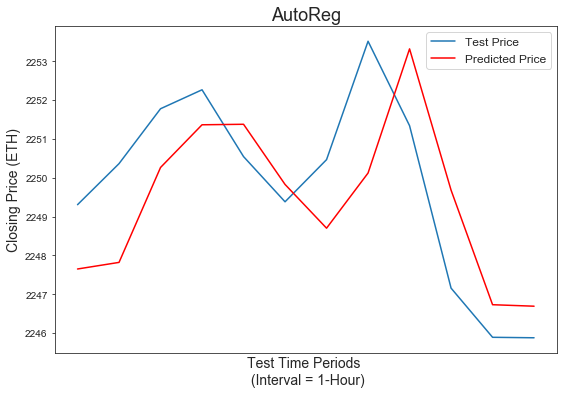

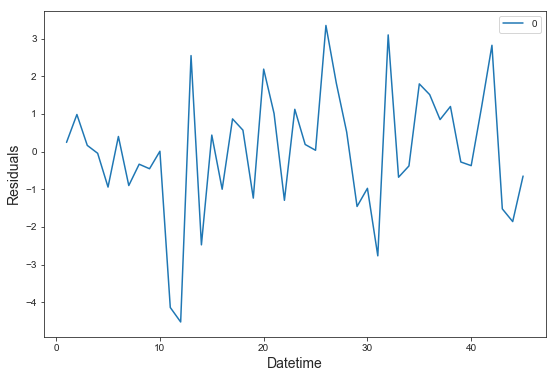

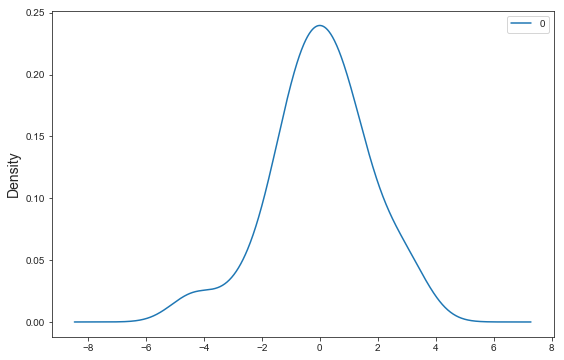

Mean of residuals:  0.013562019800176333
Standard deviation of residuals:  1.6679076020503663
KstestResult(statistic=0.9967403422886018, pvalue=2.4761099075894794e-112)
AndersonResult(statistic=0.2895179839386941, critical_values=array([0.535, 0.609, 0.731, 0.853, 1.014]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9760100841522217 and p-value is 0.467809796333313


In [53]:
run_AutoReg(hour1, lag=13)

Test MSE: 1.93616
Test R^2: 0.31369


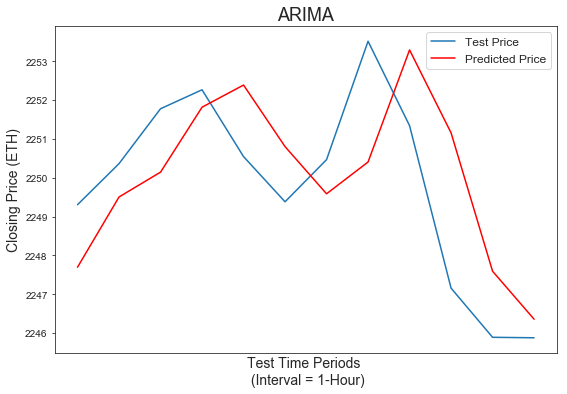

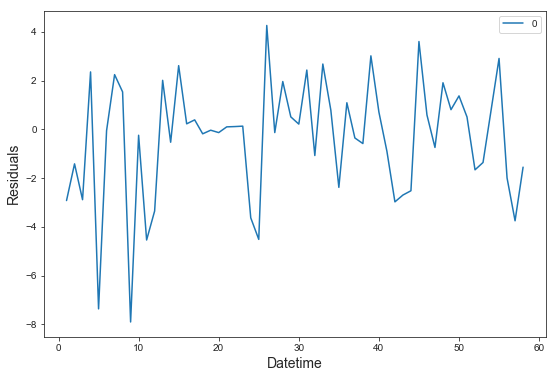

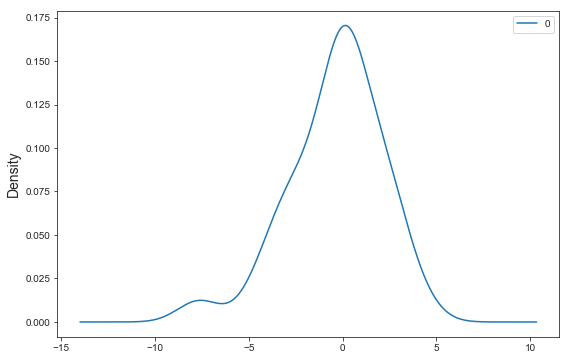

Mean of residuals:  -0.39087113576104865
Standard deviation of residuals:  2.450466862885168
KstestResult(statistic=0.9989139814256995, pvalue=2.3965730746717004e-172)
AndersonResult(statistic=0.6617198901583521, critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9569645524024963 and p-value is 0.03837186470627785


In [54]:
run_ARIMA(hour1, (5,1,0))

### 3.3 Hodrick-Prescott Filter Trend Prediction

In [8]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.ar_model import AR

In [9]:
cycle, trend = hpfilter(hour1, 50)

Test for Trend MSE: 0.025718832284886622
Test for Trend R^2: 0.9995119305738975


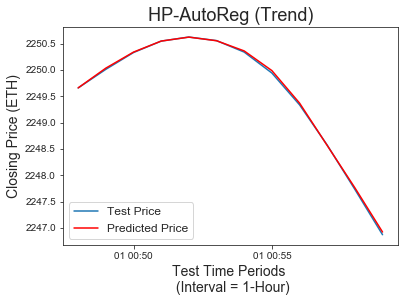

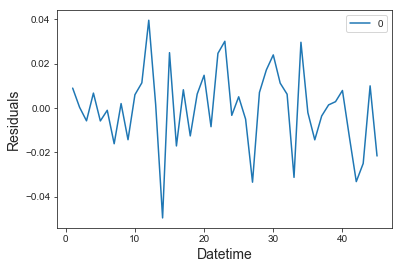

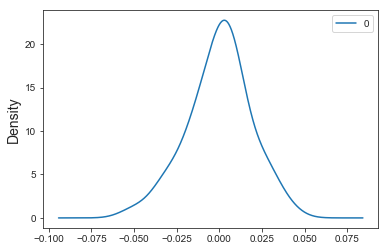

Mean of residuals:  -0.00022257016015727357
Standard deviation of residuals:  0.01809713712859854
KstestResult(statistic=0.996834953037945, pvalue=6.578655140508674e-113)
AndersonResult(statistic=0.37353726287256706, critical_values=array([0.535, 0.609, 0.731, 0.853, 1.014]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9809521436691284 and p-value is 0.6584032773971558
Test for Cycle MSE: 1.0968943201883528
Test for Cycle R^2: 0.500681594116025


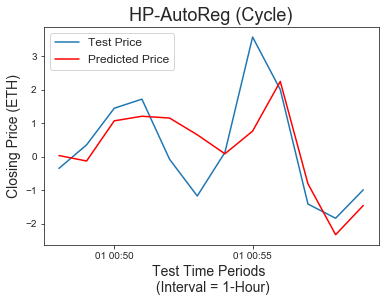

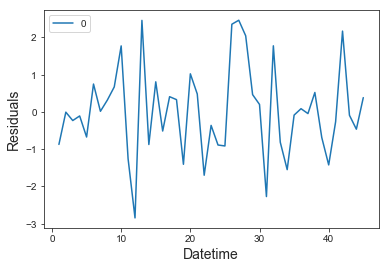

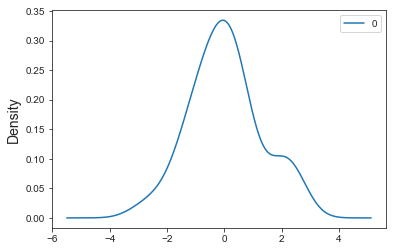

Mean of residuals:  0.026697958277240932
Standard deviation of residuals:  1.2150867265817833
KstestResult(statistic=0.990939780576415, pvalue=2.3565258178388525e-92)
AndersonResult(statistic=0.4771066423503356, critical_values=array([0.535, 0.609, 0.731, 0.853, 1.014]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9707114696502686 and p-value is 0.30722954869270325


In [10]:
component_dict = {'Cycle': cycle, 'Trend': trend}

for component in ['Trend', 'Cycle']:
    run_AutoReg(hour1, 13, title='HP-AutoReg', component=component, component_dict=component_dict)

C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to 

Test for Trend MSE: 0.02226540787765113
Test for Trend R^2: 0.9996342027627002


C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


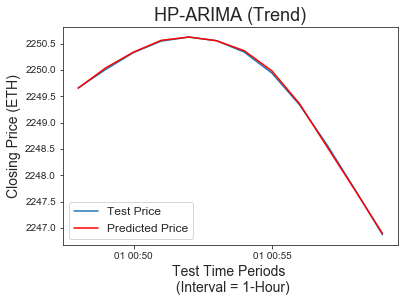

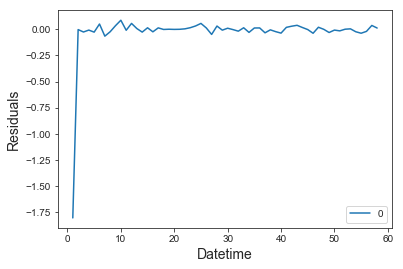

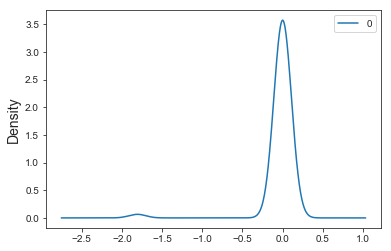

Mean of residuals:  -0.03016419800086749
Standard deviation of residuals:  0.23699031055459022
KstestResult(statistic=0.9999999999999674, pvalue=0.0)
AndersonResult(statistic=16.578572593727216, critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.1968732476234436 and p-value is 3.6479681453125226e-16
Test for Cycle MSE: 1.6411826564407601
Test for Cycle R^2: -0.11779416340387727


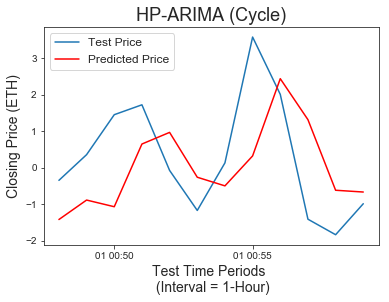

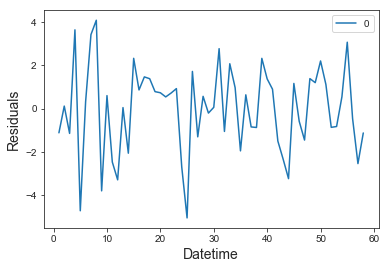

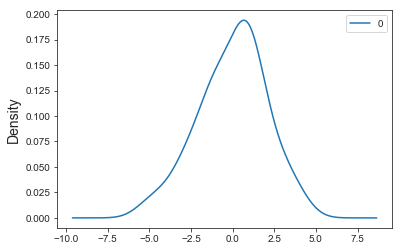

Mean of residuals:  -0.025369091798056905
Standard deviation of residuals:  1.9997494418799602
KstestResult(statistic=0.9940374120785563, pvalue=1.889070487572857e-129)
AndersonResult(statistic=0.3740684209698557, critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9825625419616699 and p-value is 0.568884015083313


In [11]:
for component in ['Trend', 'Cycle']:
    run_ARIMA(hour1, (5,1,0), title='HP-ARIMA', component=component, component_dict=component_dict)

### 3.4 Locally Weighted Regression Trend Prediction

In [12]:
from statsmodels.tsa.seasonal import STL

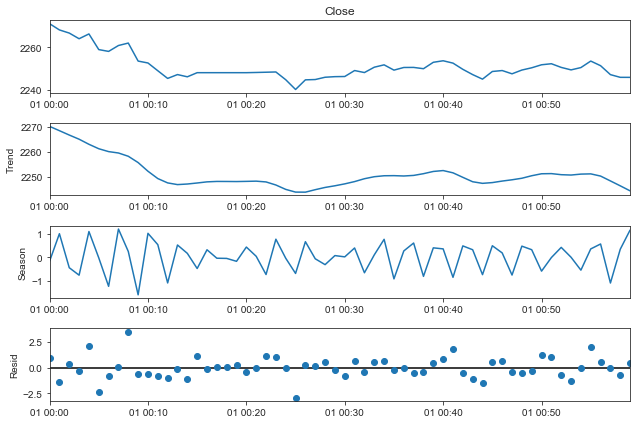

In [60]:
result = STL(hour1, period=3).fit()
result.plot()
plt.show()

Test for Trend MSE: 0.3820703594396715
Test for Trend R^2: 0.9675431110869531


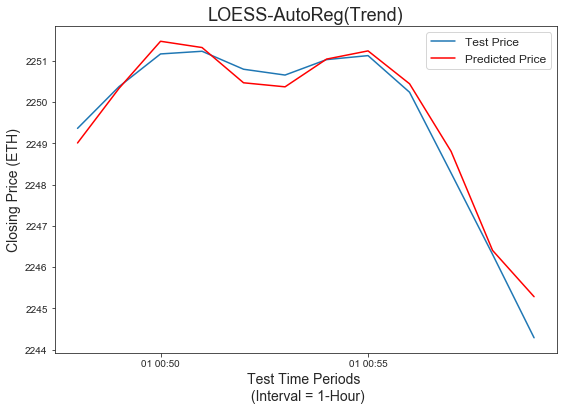

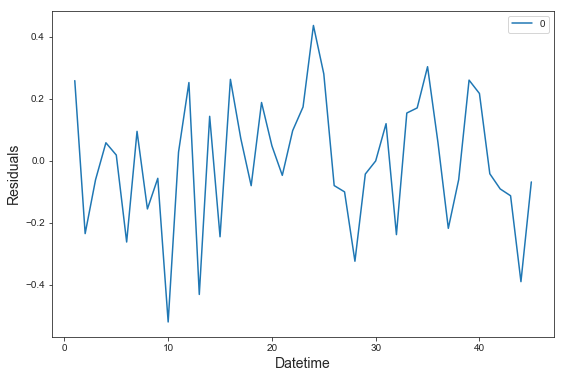

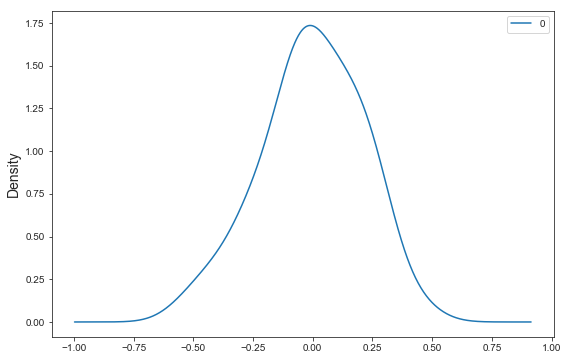

Mean of residuals:  -0.003601504730583353
Standard deviation of residuals:  0.2081905293943102
KstestResult(statistic=0.9934033707101053, pvalue=1.4808925217447797e-98)
AndersonResult(statistic=0.2770897924656168, critical_values=array([0.535, 0.609, 0.731, 0.853, 1.014]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9825480580329895 and p-value is 0.7235968708992004
Test for Seasonal MSE: 0.1300930713452794
Test for Seasonal R^2: 0.9500265518064173


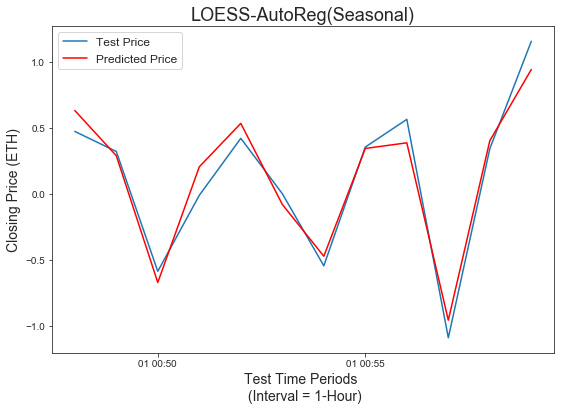

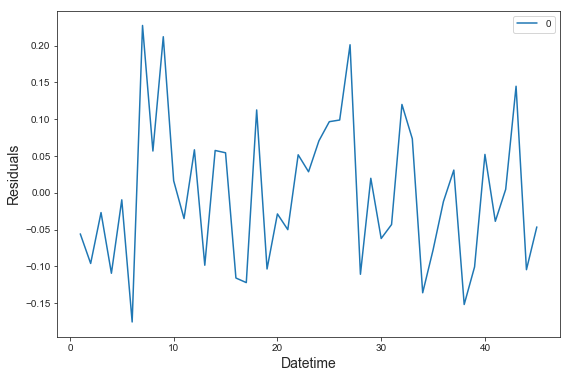

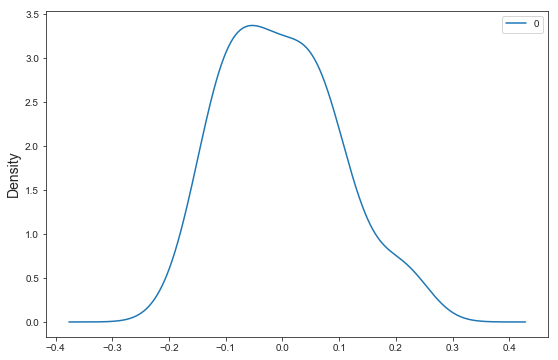

Mean of residuals:  -0.002616873514461886
Standard deviation of residuals:  0.09822122364984685
KstestResult(statistic=0.9903850199112152, pvalue=3.417492029470721e-91)
AndersonResult(statistic=0.4332637774947159, critical_values=array([0.535, 0.609, 0.731, 0.853, 1.014]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9658967852592468 and p-value is 0.20432311296463013


In [61]:
component_dict = {'Seasonal': result.seasonal, 'Trend': result.trend}

for component in ['Trend', 'Seasonal']:
    run_AutoReg(hour1, 13, title='LOESS-AutoReg', component=component, component_dict=component_dict)

Test for Trend MSE: 0.4023519903777295
Test for Trend R^2: 0.9640058018351828


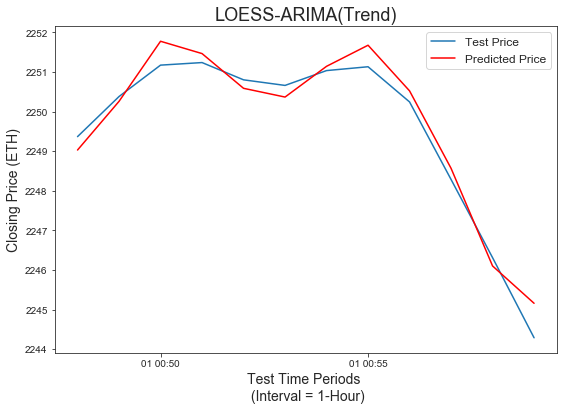

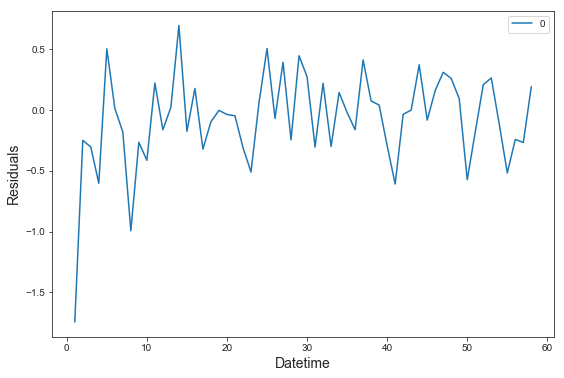

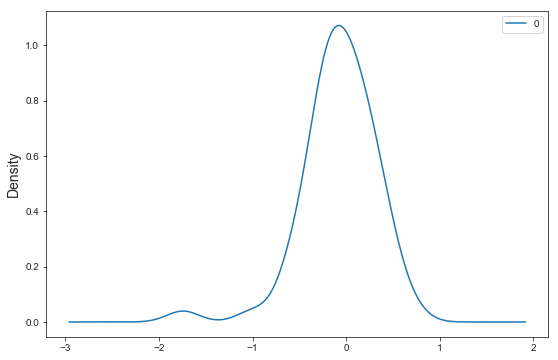

Mean of residuals:  -0.07442204713322162
Standard deviation of residuals:  0.38899961553047124
KstestResult(statistic=0.9999910453934782, pvalue=3.309233458466503e-293)
AndersonResult(statistic=0.7448147148675872, critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9164310693740845 and p-value is 0.0006929731462150812
Test for Seasonal MSE: 0.1554592328287635
Test for Seasonal R^2: 0.9286384912609762


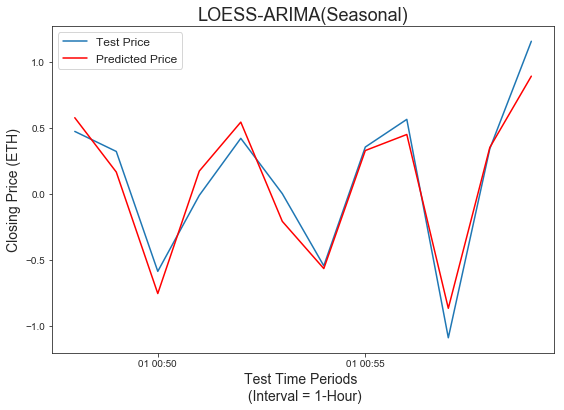

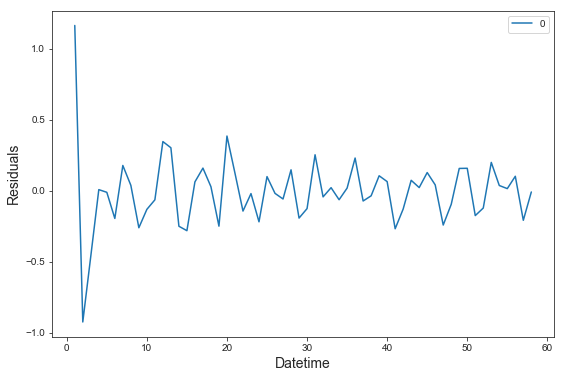

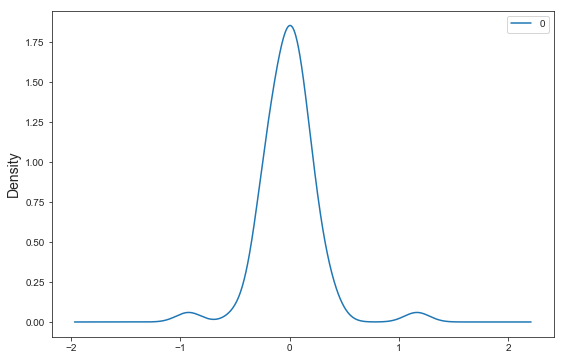

Mean of residuals:  -0.006601152365330424
Standard deviation of residuals:  0.2580674744043248
KstestResult(statistic=0.9999971586694157, pvalue=4.05e-322)
AndersonResult(statistic=1.6176056863995782, critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.8580905199050903 and p-value is 7.232629286590964e-06


In [62]:
for component in ['Trend', 'Seasonal']:
    run_ARIMA(hour1, (5,1,0), title='LOESS-ARIMA', component=component, component_dict=component_dict)

## **2-Hour Data**

#### 3.1 *cont.*

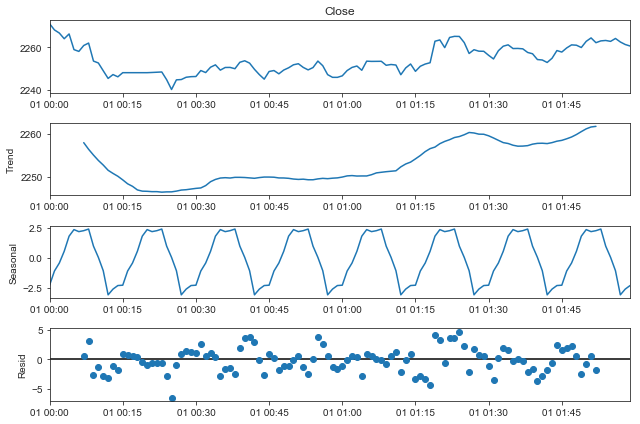

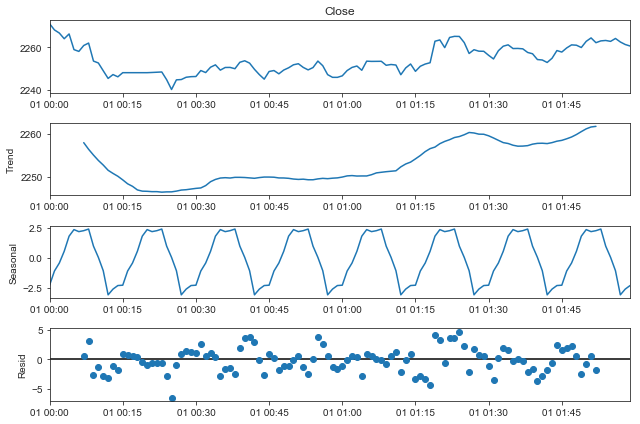

In [63]:
decompfreq = 15
h2_result = sd(hour2, model='Multiplicative', period=decompfreq)
h2_trend = h2_result.trend
h2_season = h2_result.seasonal
h2_error = h2_result.resid

plt.rcParams['figure.figsize'] = [9.0,6.0]
h2_result.plot()

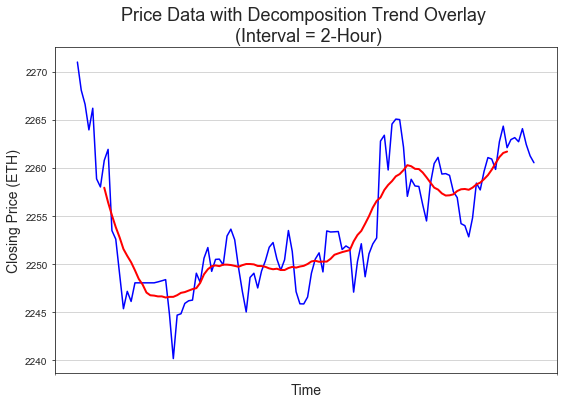

In [64]:
trend_plot(hour2, h2_trend, '2-Hour')

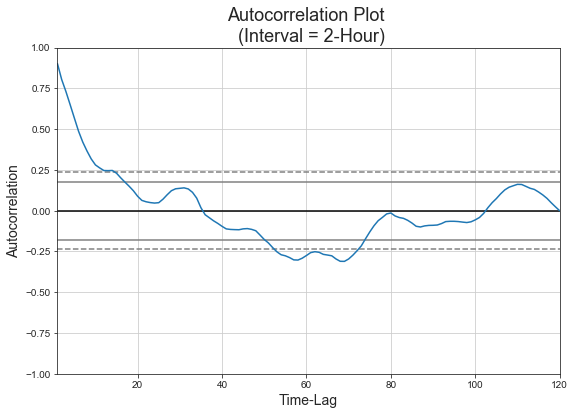

In [65]:
autocorrelation_plot(h2_eth)
plt.ylabel('Autocorrelation', fontsize=14)
plt.xlabel('Time-Lag', fontsize=14)
plt.title('Autocorrelation Plot \n (Interval = 2-Hour)', fontsize=18)
plt.show()

#### 3.2 *cont.*

Test MSE: 1.90026
Test R^2: 0.65830


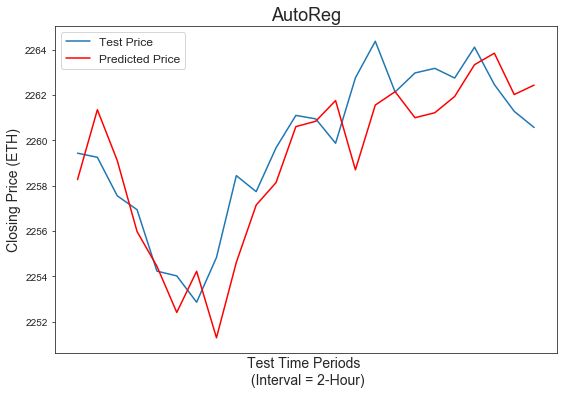

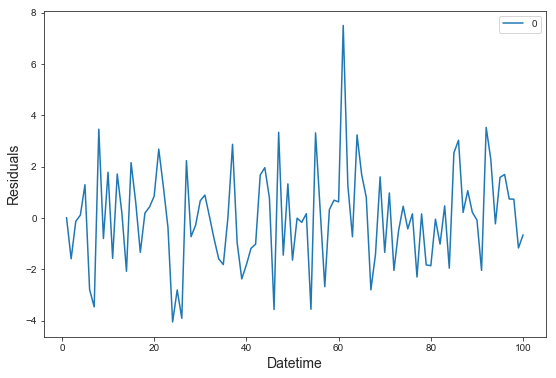

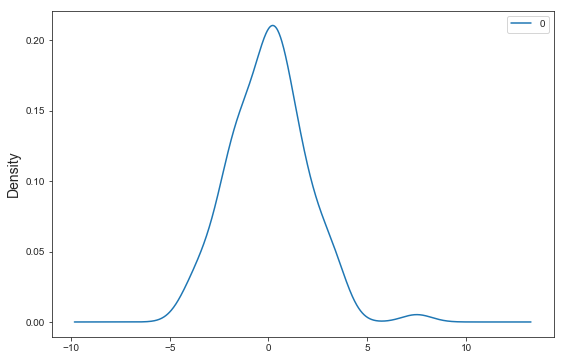

Mean of residuals:  0.01526513673189129
Standard deviation of residuals:  1.9119819406732614
KstestResult(statistic=0.9999551354740568, pvalue=0.0)
AndersonResult(statistic=0.3001928284304398, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9765804409980774 and p-value is 0.07176444679498672


In [75]:
run_AutoReg(hour2, lag=18, interval='2-Hour')

Test MSE: 1.82030
Test R^2: 0.68645


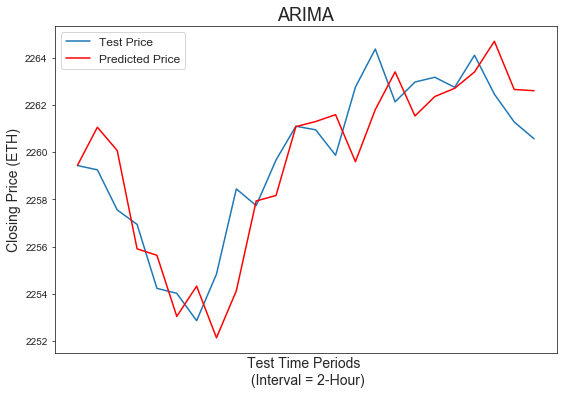

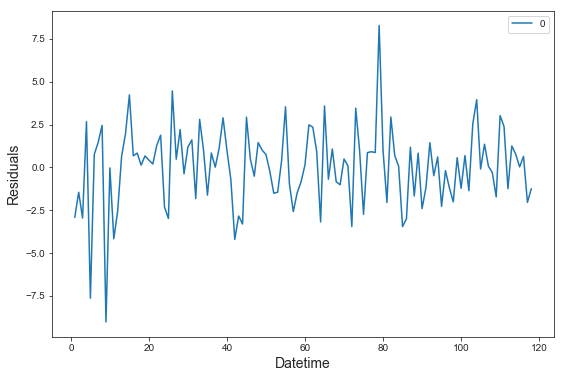

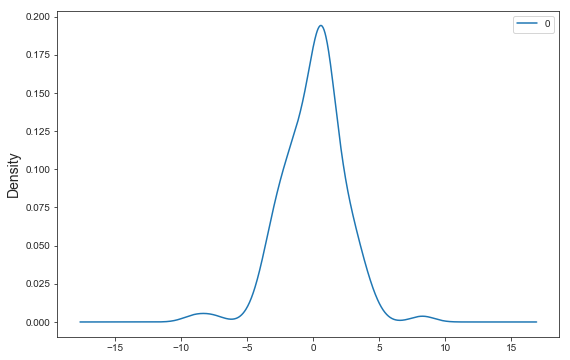

Mean of residuals:  0.01023515575560064
Standard deviation of residuals:  2.3173807710304906
KstestResult(statistic=0.99995156451378, pvalue=0.0)
AndersonResult(statistic=1.027216203947873, critical_values=array([0.558, 0.636, 0.763, 0.889, 1.058]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9588302969932556 and p-value is 0.0011452584294602275


In [79]:
run_ARIMA(hour2, order=(16,1,0), interval='2-Hour')

#### 3.3 *cont.*

In [13]:
cycle, trend = hpfilter(hour2, 50)

Test for Trend MSE: 0.02837931605114973
Test for Trend R^2: 0.9999652785445728


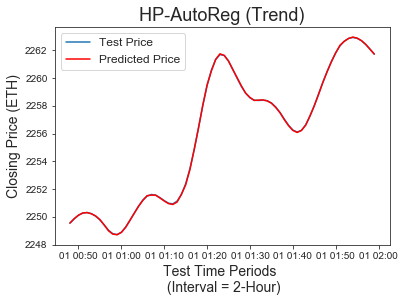

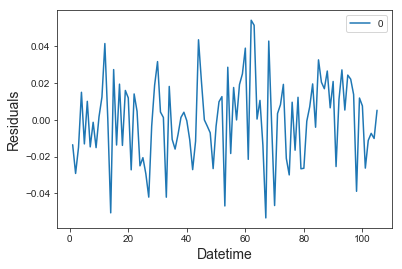

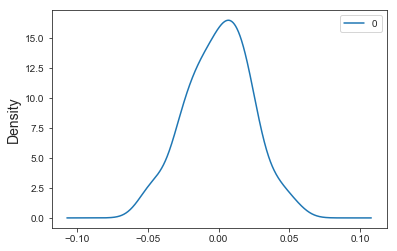

Mean of residuals:  0.00013848891229004256
Standard deviation of residuals:  0.02255957382606132
KstestResult(statistic=0.9916347506476889, pvalue=1.4498182081578427e-218)
AndersonResult(statistic=0.2638688954632329, critical_values=array([0.556, 0.633, 0.76 , 0.886, 1.054]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9911489486694336 and p-value is 0.728043258190155
Test for Cycle MSE: 1.5133827714182122
Test for Cycle R^2: 0.4418880006414667


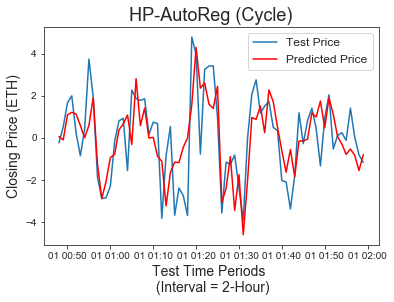

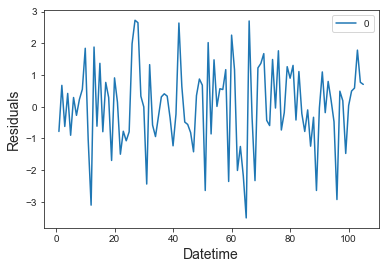

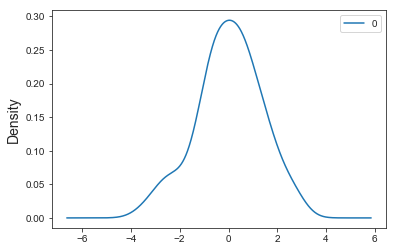

Mean of residuals:  0.019388051416974347
Standard deviation of residuals:  1.320420531150976
KstestResult(statistic=0.9962352914215792, pvalue=5.660087903630324e-255)
AndersonResult(statistic=0.332358594088646, critical_values=array([0.556, 0.633, 0.76 , 0.886, 1.054]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9860619306564331 and p-value is 0.34342947602272034


In [14]:
component_dict = {'Cycle': cycle, 'Trend': trend}

for component in ['Trend', 'Cycle']:
    run_AutoReg(hour2, 18, title='HP-AutoReg', interval='2-Hour', component=component, component_dict=component_dict)

C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to 

Test for Trend MSE: 0.03162663197775021
Test for Trend R^2: 0.9999568778940849


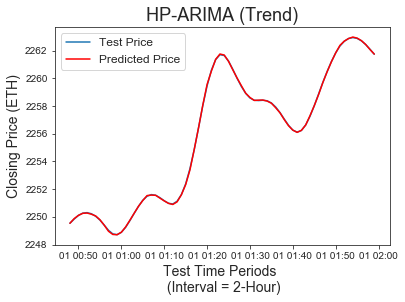

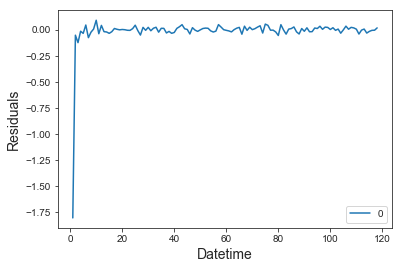

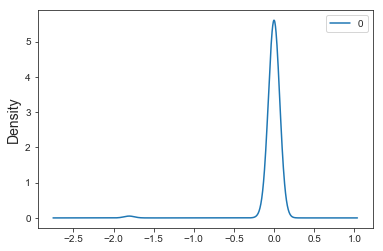

Mean of residuals:  -0.016645218450013106
Standard deviation of residuals:  0.1678618998866417
KstestResult(statistic=1.0, pvalue=0.0)
AndersonResult(statistic=30.113048779666485, critical_values=array([0.558, 0.636, 0.763, 0.889, 1.058]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.17215651273727417 and p-value is 7.769735917946726e-23


C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Test for Cycle MSE: 1.7707514614209494
Test for Cycle R^2: 0.23591969302508675


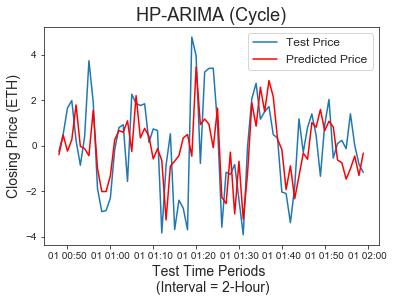

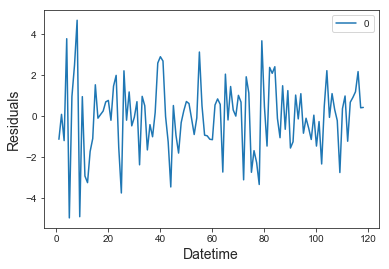

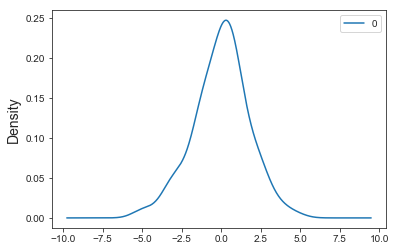

Mean of residuals:  -0.008927235135668864
Standard deviation of residuals:  1.731819206598623
KstestResult(statistic=0.9978364570594647, pvalue=7.08861291e-315)
AndersonResult(statistic=0.5981523363526264, critical_values=array([0.558, 0.636, 0.763, 0.889, 1.058]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.986968994140625 and p-value is 0.31748253107070923


In [15]:
for component in ['Trend', 'Cycle']:
    run_ARIMA(hour2, (16,1,0), title='HP-ARIMA', interval='2-Hour', component=component, component_dict=component_dict)

#### 3.4 *cont.*

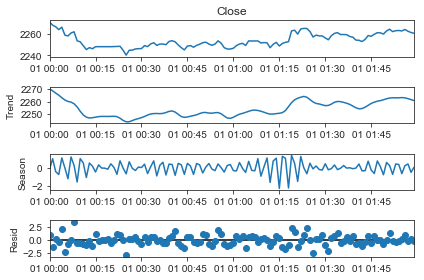

In [16]:
result = STL(hour2, period=3).fit()
result.plot()
plt.show()

Test for Trend MSE: 0.2603993915817173
Test for Trend R^2: 0.9974215707873704


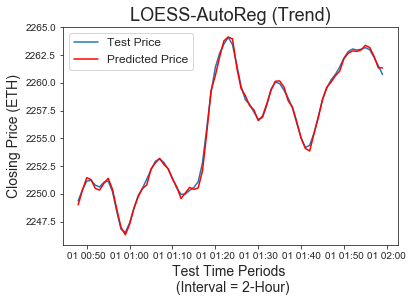

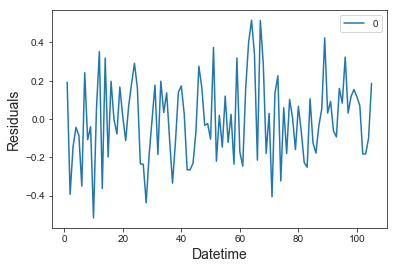

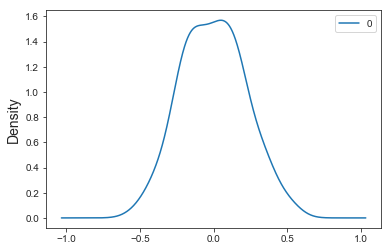

Mean of residuals:  -0.0019164891860306117
Standard deviation of residuals:  0.21532242895203174
KstestResult(statistic=0.9919000725281378, pvalue=4.915284512930785e-220)
AndersonResult(statistic=0.2534183902645708, critical_values=array([0.556, 0.633, 0.76 , 0.886, 1.054]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9923006296157837 and p-value is 0.820420503616333
Test for Seasonal MSE: 0.11456258351759226
Test for Seasonal R^2: 0.9736719126940823


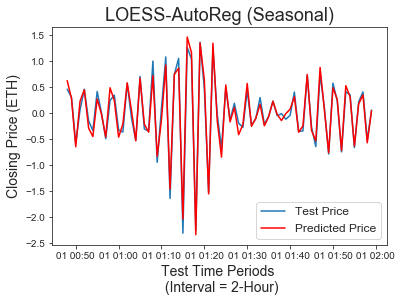

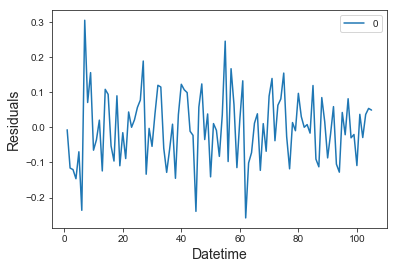

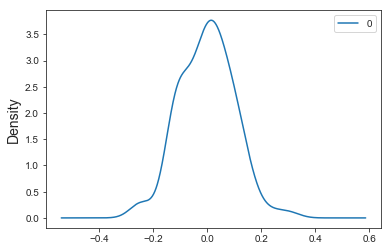

Mean of residuals:  -0.0008749462130709912
Standard deviation of residuals:  0.0995589377673734
KstestResult(statistic=0.9989555228787766, pvalue=1.92938009305e-313)
AndersonResult(statistic=0.2994142393612407, critical_values=array([0.556, 0.633, 0.76 , 0.886, 1.054]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9892929792404175 and p-value is 0.5727895498275757


In [17]:
component_dict = {'Seasonal': result.seasonal, 'Trend': result.trend}

for component in ['Trend', 'Seasonal']:
    run_AutoReg(hour2, 13, title='LOESS-AutoReg', interval='2-Hour', component=component, component_dict=component_dict)

Test for Trend MSE: 0.318373775101608
Test for Trend R^2: 0.9961456614675142


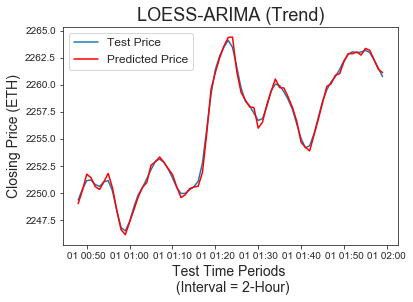

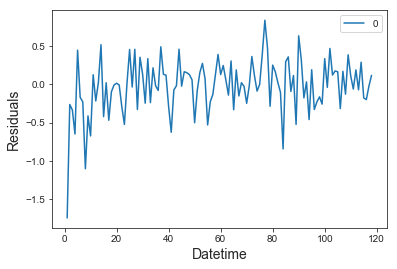

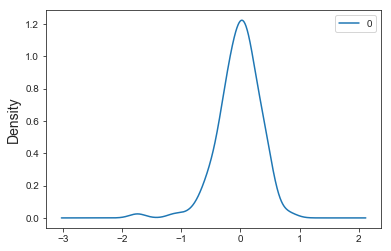

Mean of residuals:  -0.02525187071178075
Standard deviation of residuals:  0.3521004797887449
KstestResult(statistic=0.99999946299941, pvalue=0.0)
AndersonResult(statistic=1.023022455370679, critical_values=array([0.558, 0.636, 0.763, 0.889, 1.058]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9375806450843811 and p-value is 3.427259434829466e-05


C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Test for Seasonal MSE: 0.16168567331115305
Test for Seasonal R^2: 0.9475582965079995


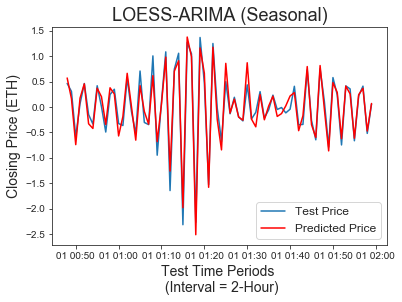

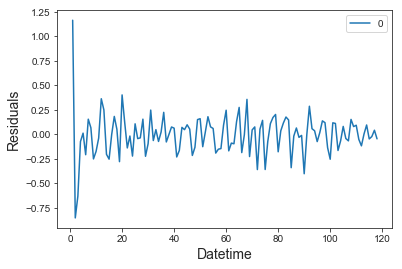

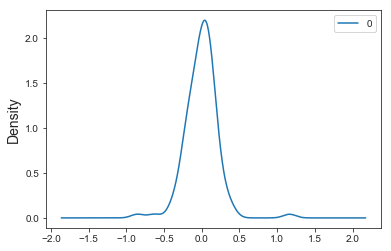

Mean of residuals:  -0.004184737267981802
Standard deviation of residuals:  0.2145673713553342
KstestResult(statistic=0.9999999743266368, pvalue=0.0)
AndersonResult(statistic=1.8919672517538686, critical_values=array([0.558, 0.636, 0.763, 0.889, 1.058]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.8911595940589905 and p-value is 8.668352080576369e-08


In [18]:
for component in ['Trend', 'Seasonal']:
    run_ARIMA(hour2, (5,1,0), title='LOESS-ARIMA', interval='2-Hour', component=component, component_dict=component_dict)

## **3-Hour Data**

#### 3.1 *cont*

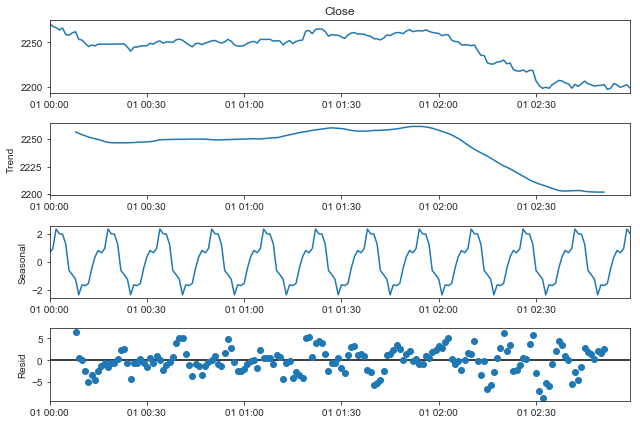

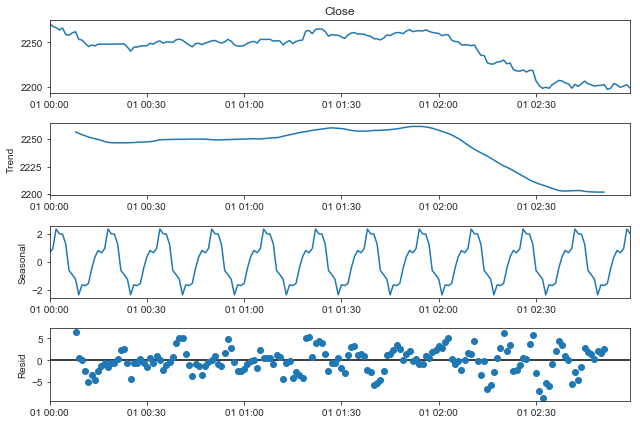

In [91]:
decompfreq = 16
h3_result = sd(hour3, model='Multiplicative', period=decompfreq)
h3_trend = h3_result.trend
h3_season = h3_result.seasonal
h3_error = h3_result.resid

plt.rcParams['figure.figsize'] = [9.0,6.0]
h3_result.plot()

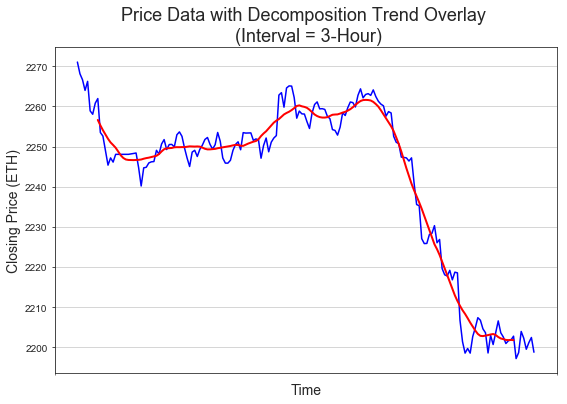

In [92]:
trend_plot(hour3, h3_trend, '3-Hour')

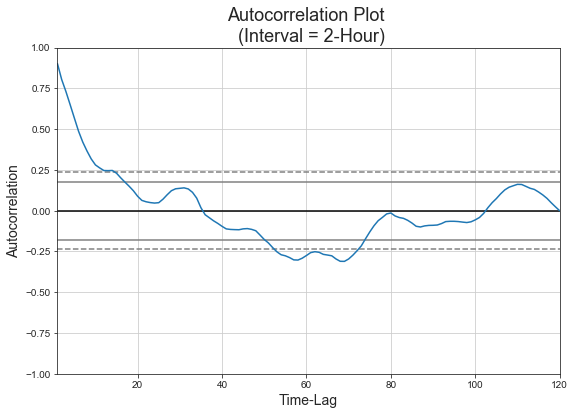

In [93]:
autocorrelation_plot(h2_eth)
plt.ylabel('Autocorrelation', fontsize=14)
plt.xlabel('Time-Lag', fontsize=14)
plt.title('Autocorrelation Plot \n (Interval = 2-Hour)', fontsize=18)
plt.show()

#### 3.2 *cont.*

Test MSE: 3.55078
Test R^2: 0.69824


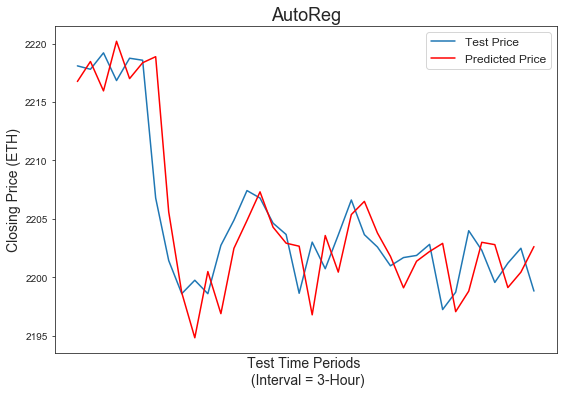

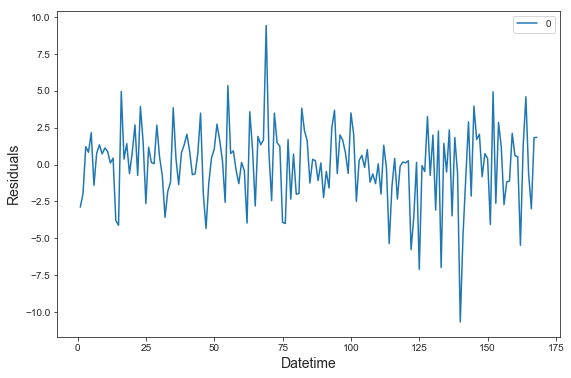

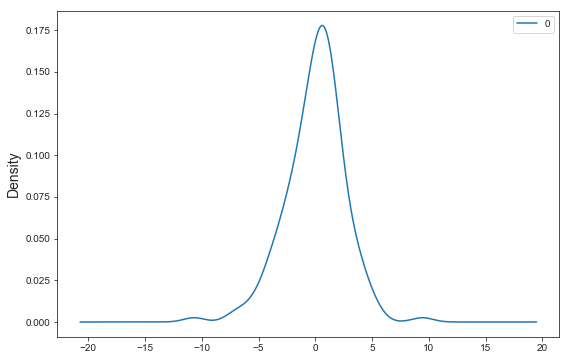

Mean of residuals:  -0.0008488821122390229
Standard deviation of residuals:  2.568454090612851
KstestResult(statistic=0.9999836206556938, pvalue=0.0)
AndersonResult(statistic=1.286517290446426, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.068]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9690044522285461 and p-value is 0.0008235776331275702


In [106]:
run_AutoReg(hour3, lag=10, interval='3-Hour')

Test MSE: 3.43966
Test R^2: 0.71683


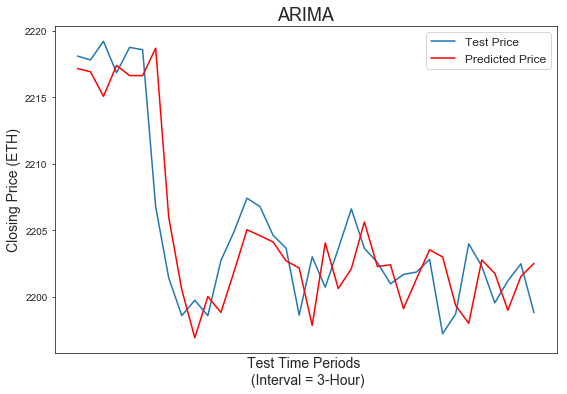

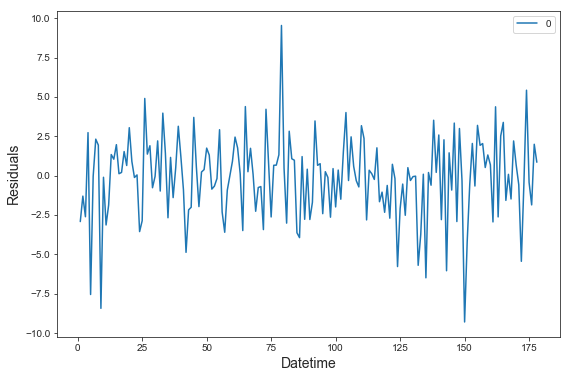

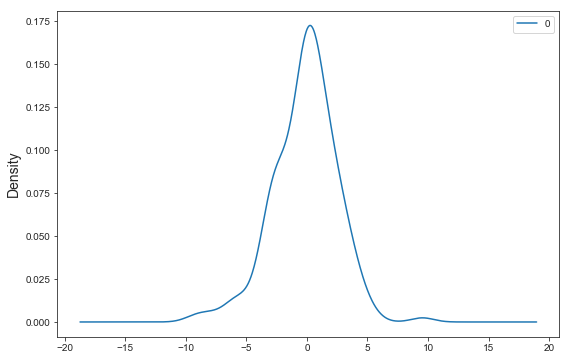

Mean of residuals:  -0.15602480655197876
Standard deviation of residuals:  2.6160788083722997
KstestResult(statistic=0.9998941155378132, pvalue=0.0)
AndersonResult(statistic=1.1606309327487736, critical_values=array([0.564, 0.642, 0.77 , 0.899, 1.069]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9739284515380859 and p-value is 0.002017780439928174


In [110]:
run_ARIMA(hour3, order=(16,1,0), interval='3-Hour')

#### 3.3 *cont.*

In [19]:
cycle, trend = hpfilter(hour3, 50)

Test for Trend MSE: 0.03585710530868345
Test for Trend R^2: 0.9999975328206856


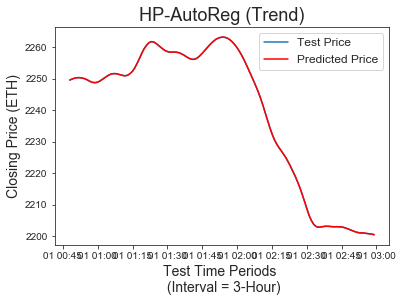

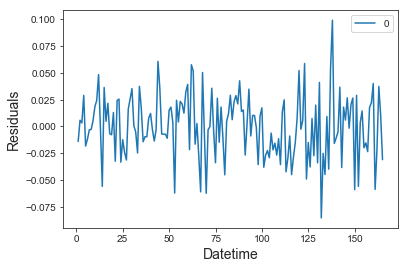

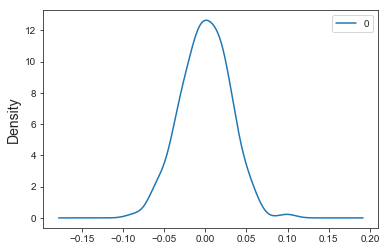

Mean of residuals:  -2.608944686829945e-05
Standard deviation of residuals:  0.02937056216438796
KstestResult(statistic=0.9996379285182484, pvalue=0.0)
AndersonResult(statistic=0.15455047344062223, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.067]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9954158067703247 and p-value is 0.8934869766235352
Test for Cycle MSE: 1.9209283786449145
Test for Cycle R^2: 0.37889857444814157


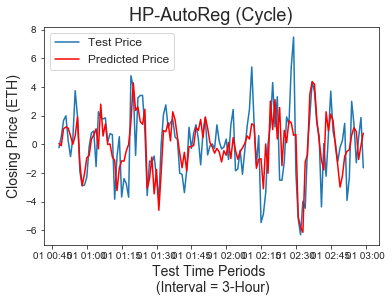

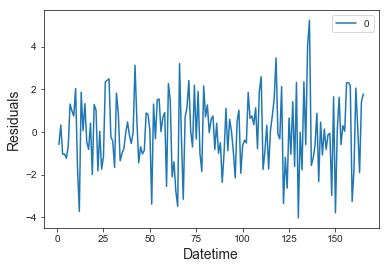

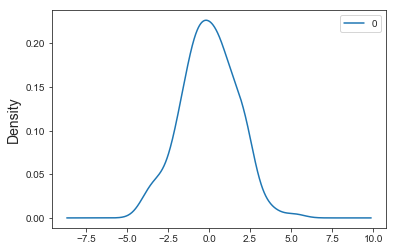

Mean of residuals:  0.001952933767563672
Standard deviation of residuals:  1.654482484490612
KstestResult(statistic=0.9992184802206331, pvalue=0.0)
AndersonResult(statistic=0.20760891617140942, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.067]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9940951466560364 and p-value is 0.7480968236923218


In [20]:
component_dict = {'Cycle': cycle, 'Trend': trend}

for component in ['Trend', 'Cycle']:
    run_AutoReg(hour3, 10, title='HP-AutoReg', interval='3-Hour', component=component, component_dict=component_dict)

C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to 

Test for Trend MSE: 0.03680382561637294
Test for Trend R^2: 0.9999974008209952


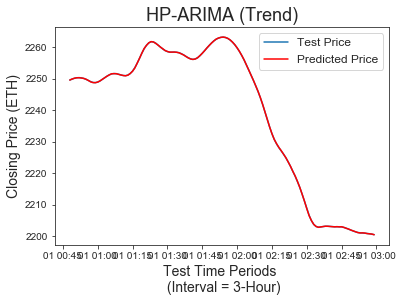

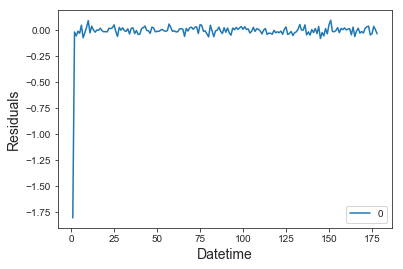

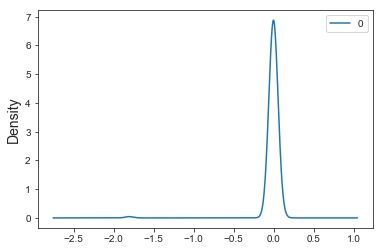

Mean of residuals:  -0.01247115333260328
Standard deviation of residuals:  0.13816379015448466
KstestResult(statistic=1.0, pvalue=0.0)
AndersonResult(statistic=38.994139476753446, critical_values=array([0.564, 0.642, 0.77 , 0.899, 1.069]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.1823512315750122 and p-value is 2.768862103168897e-27


C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Test for Cycle MSE: 2.131811144968457
Test for Cycle R^2: 0.23504191783639405


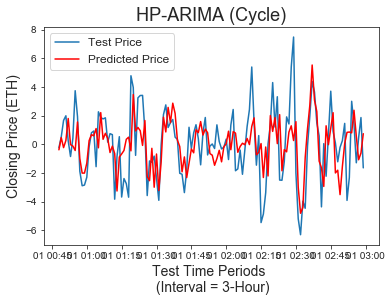

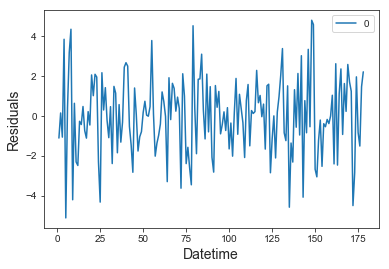

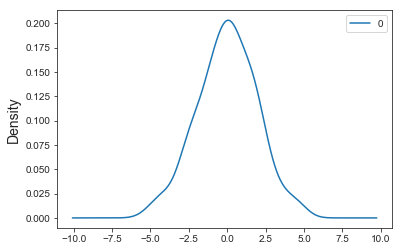

Mean of residuals:  -0.006135123844179594
Standard deviation of residuals:  1.9208523902076877
KstestResult(statistic=0.9961331384993862, pvalue=0.0)
AndersonResult(statistic=0.21082782734259808, critical_values=array([0.564, 0.642, 0.77 , 0.899, 1.069]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.99493807554245 and p-value is 0.8088449835777283


In [21]:
for component in ['Trend', 'Cycle']:
    run_ARIMA(hour3, (16,1,0), title='HP-ARIMA', interval='3-Hour', component=component, component_dict=component_dict)

#### 3.4 *cont.*

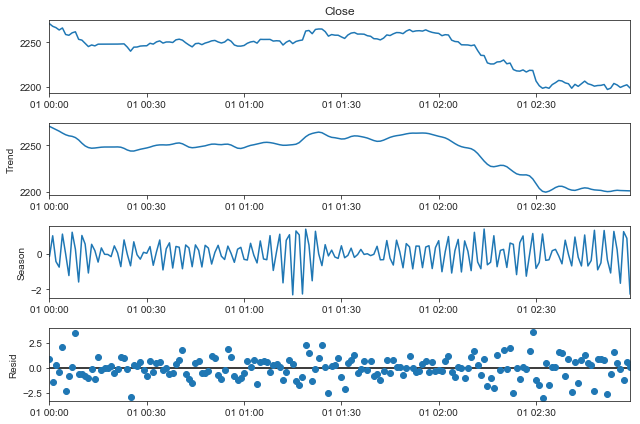

In [114]:
result = STL(hour3, period=3).fit()
result.plot()
plt.show()

Test for Trend MSE: 0.34789071793259535
Test for Trend R^2: 0.99976922062734


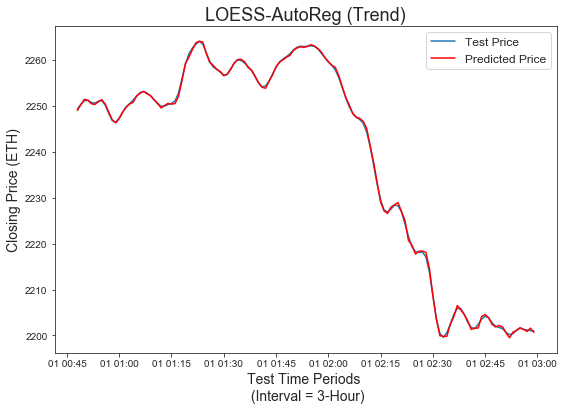

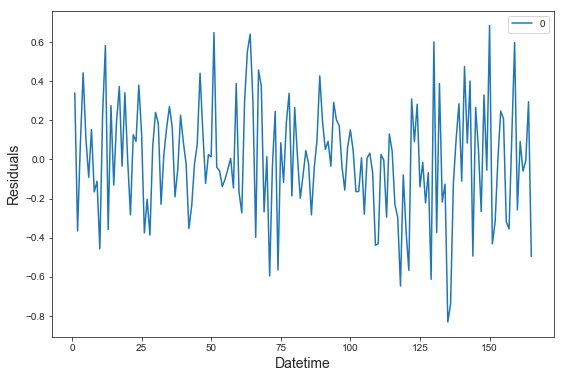

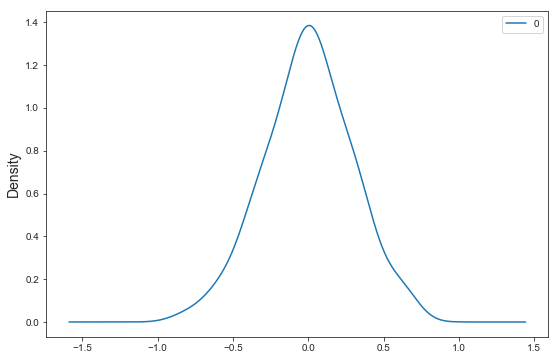

Mean of residuals:  -0.000501244491004565
Standard deviation of residuals:  0.2906503873950726
KstestResult(statistic=0.997854301198753, pvalue=0.0)
AndersonResult(statistic=0.16485625192706266, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.067]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9955667853355408 and p-value is 0.9068509340286255
Test for Seasonal MSE: 0.15313159071879445
Test for Seasonal R^2: 0.9621400562316327


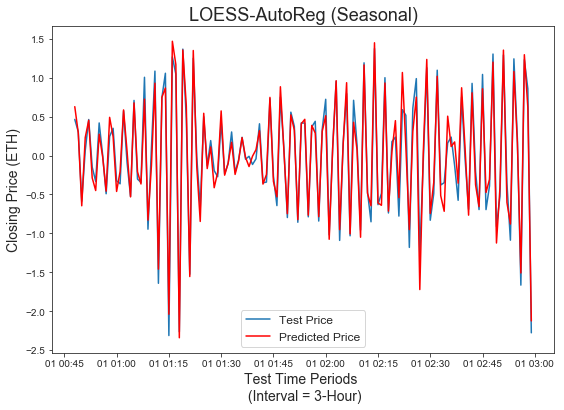

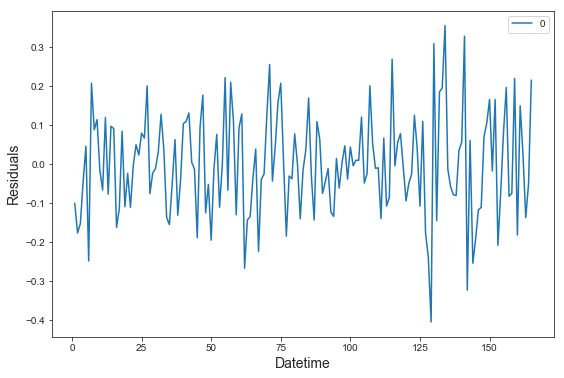

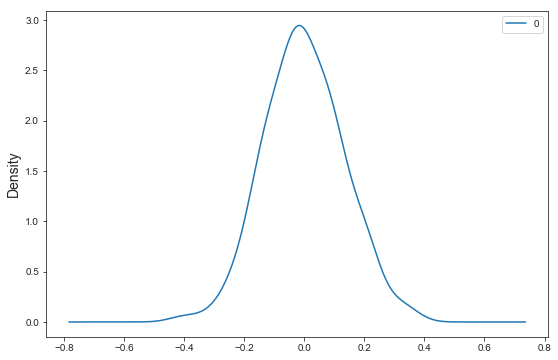

Mean of residuals:  -0.0005403109167434082
Standard deviation of residuals:  0.13063341034320833
KstestResult(statistic=0.9989984363371458, pvalue=0.0)
AndersonResult(statistic=0.20776338757394797, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.067]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.996313750743866 and p-value is 0.9592442512512207


In [115]:
component_dict = {'Seasonal': result.seasonal, 'Trend': result.trend}

for component in ['Trend', 'Seasonal']:
    run_AutoReg(hour3, 10, title='LOESS-AutoReg', interval='3-Hour', component=component, component_dict=component_dict)

C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:60

Test for Trend MSE: 0.29775261219941224
Test for Trend R^2: 0.9998309471619884


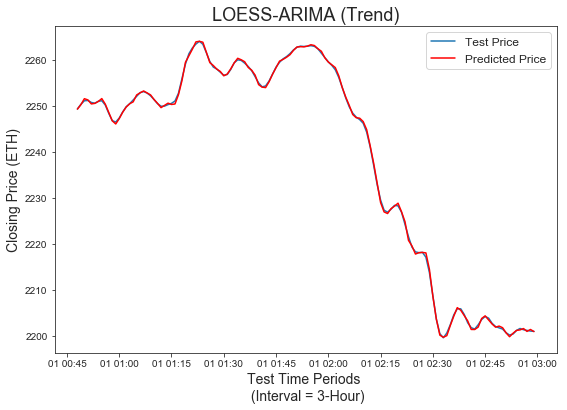

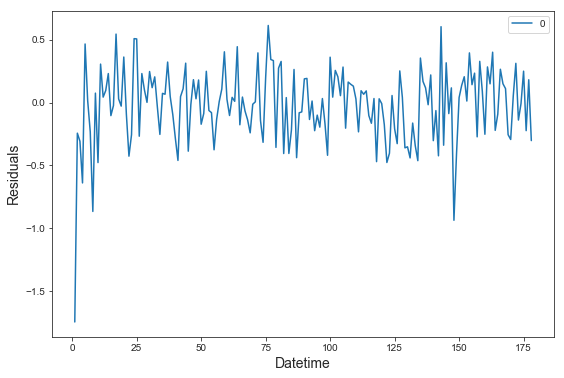

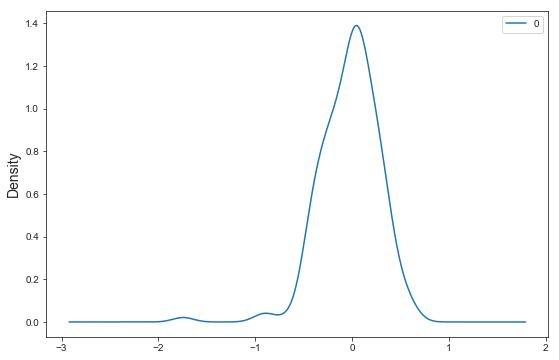

Mean of residuals:  -0.023038377905693144
Standard deviation of residuals:  0.3002809164264324
KstestResult(statistic=0.9999999950296572, pvalue=0.0)
AndersonResult(statistic=0.9809972154262141, critical_values=array([0.564, 0.642, 0.77 , 0.899, 1.069]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.9352694749832153 and p-value is 3.6099055478189257e-07


C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\razor\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:60

Test for Seasonal MSE: 0.15614151175178786
Test for Seasonal R^2: 0.9606370955150251


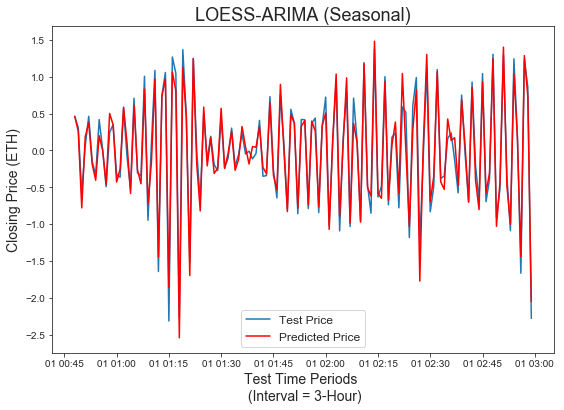

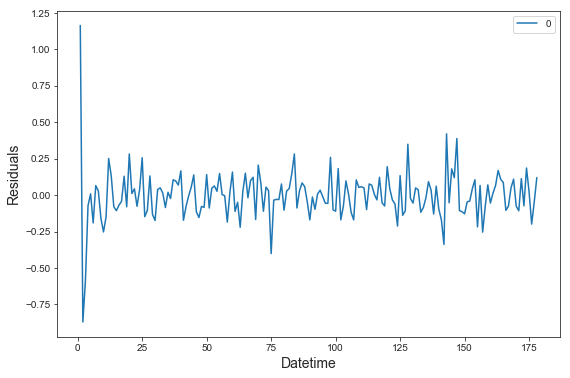

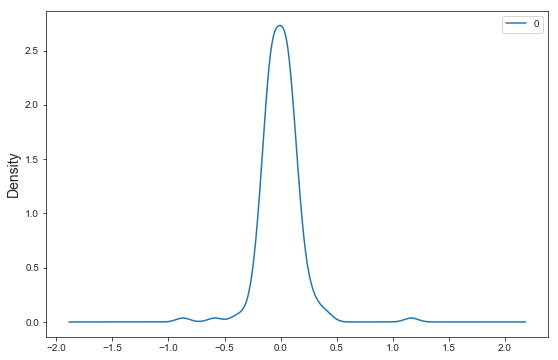

Mean of residuals:  -0.002794502807475984
Standard deviation of residuals:  0.17356631725879665
KstestResult(statistic=0.9999999999912326, pvalue=0.0)
AndersonResult(statistic=3.944203468591354, critical_values=array([0.564, 0.642, 0.77 , 0.899, 1.069]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Shapiro-Wilke test statistic is 0.8421096801757812 and p-value is 1.3280697071585412e-12


In [116]:
for component in ['Trend', 'Seasonal']:
    run_ARIMA(hour3, (16,1,0), title='LOESS-ARIMA', interval='3-Hour', component=component, component_dict=component_dict)